<a href="https://colab.research.google.com/github/Mr-Kondo/Open/blob/main/Anomaly_Sound_Detection_AE_WAV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [機械稼働音の異常検知](https://signate.jp/competitions/358)

## Refference

1 [音声ファイル特徴量変換（その5）メルスペクトログラム(TensorFlow)](https://work-in-progress.hatenablog.com/entry/2020/03/08/095914)  
2 [Tensorflow, 簡単な音声認識: キーワードの認識](https://www.tensorflow.org/tutorials/audio/simple_audio?hl=ja)  
3 [「ToyADMOS:異常音検知」：AutoEncoder](https://note.com/toshi_sugi/n/nc4a5b9c4d6cf)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp "/content/drive/MyDrive/01_input.zip" ./

import shutil
shutil.unpack_archive('./01_input.zip', './')

## Import modules

In [3]:
import os
import pathlib
import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras.models import Model

import seaborn as sns

from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Define Functions

In [4]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio #, labels

# Load Audio File
def load_data(filename):
  wav_loader = io_ops.read_file(filename)
  data, sr = tf.audio.decode_wav(wav_loader,
                                  desired_channels=1)
  # channelの次元を削除
  data_ = tf.squeeze(data)
  # batch_sizeの次元を追加
  data__ = tf.expand_dims(data_, axis=0)
  return data__, sr

def get_fft(waveform):
  # 波形をフーリエ変換
  # 周波数はlog10スケールに変換
  waveform = tf.complex(waveform, 0.0)
  fft = tf.signal.fft(waveform)
  fft = tf.abs(fft)
  # Convert the frequencies to log scale and transpose
  fft_log_spec = tf.experimental.numpy.log10((fft + 2.2204460492503131e-16) / 2.2204460492503131e-16)
  fft_log_spec = fft_log_spec[0:len(fft)//2]
  return fft_log_spec

def get_sftf_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
    # Input: A Tensor of [batch_size, num_samples]
    # mono PCM samples in the range [-1, 1].
  sftf = tf.signal.stft(waveform,
                        frame_length=480,
                        frame_step=128,
                        fft_length=512)

  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(sftf)

  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

def get_mel_Frequency(stft_spectrogram):
    # STFT-bin
    n_stft_bin = stft_spectrogram.shape[-1]          # --> 257 (= FFT size / 2 + 1)

    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins=128,
        num_spectrogram_bins=n_stft_bin,
        sample_rate=16000,
        lower_edge_hertz=0.0,
        upper_edge_hertz=8000.0
    )
    # --> shape=(257, 128) = (FFT size / 2 + 1, num of mel bins)

    mel_spectrograms = tf.tensordot(
        stft_spectrogram,             # (1, 98?, 257)
        linear_to_mel_weight_matrix,  # (257, 128)
        1)

    return mel_spectrograms

def log_mel(mel_spectrograms):
  mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
  return mel_spectrograms

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

## Read Audio(.wav) Data

### Train Notmal

In [5]:
# オーディオクリップをfilenamesというリストに抽出します
filenames = glob.glob('./wav/train_normal/normal/*.wav')
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Example file tensor:', filenames[0])

Number of total examples: 300
Example file tensor: ./wav/train_normal/normal/268.wav


In [6]:
files_ds = tf.data.Dataset.from_tensor_slices(filenames)

train_data, val_data,= train_test_split(list(filenames),
                                        test_size=0.2,
                                        random_state=seed)

print("num of train_data_normal: ", len(train_data))
print("num of test_data_normal: ", len(val_data))

num of train_data_normal:  240
num of test_data_normal:  60


In [7]:
# オーディオファイルの形状を確認
test_file = tf.io.read_file(filenames[0])#DATASET_PATH+'/NormalSound_IND/1200010001_ToyCar_case2_normal_IND_ch1_0001.wav')
test_audio, sampling_rate = tf.audio.decode_wav(contents=test_file)
# tf.audio.decode_wavによって返されるテンソルの形状は[samples, channels]
# channelsはモノラルの場合は1 、ステレオの場合は2
test_audio.shape

TensorShape([160000, 1])

In [8]:
# Audio Setting
Data_num = test_audio.shape[0]
Sampling_freq = sampling_rate.numpy()
time_length = Data_num / Sampling_freq

print("Data数：", Data_num)
print("サンプリング周波数[Hz]：", Sampling_freq)
print("時間窓長[sec]:", time_length)
print("分析周波数レンジ[Hz]:", Sampling_freq / 2)

Data数： 160000
サンプリング周波数[Hz]： 16000
時間窓長[sec]: 10.0
分析周波数レンジ[Hz]: 8000.0


In [9]:
# データセットの生のWAVオーディオファイルをオーディオテンソルに前処理する関数を定義
# normalized to the [-1.0, 1.0] range
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1) # モノラル信号のため、チャンネル軸を除去

In [10]:
# すべてをまとめる別のヘルパー関数get_waveformを定義
# 入力はWAVオーディオファイル名です。
# 出力は、教師あり学習の準備ができているオーディオテンソルを含むタプルです。
def get_waveform(file_path):
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform

In [11]:
AUTOTUNE = tf.data.AUTOTUNE

# 前に定義したget_waveform使用して、
# Dataset.from_tensor_slicesとDataset.mapを使用してtf.data.Datasetを作成します。

files_ds = tf.data.Dataset.from_tensor_slices(train_data)

waveform_ds = files_ds.map(
    map_func=get_waveform,
    num_parallel_calls=AUTOTUNE) # トレーニングセット作成

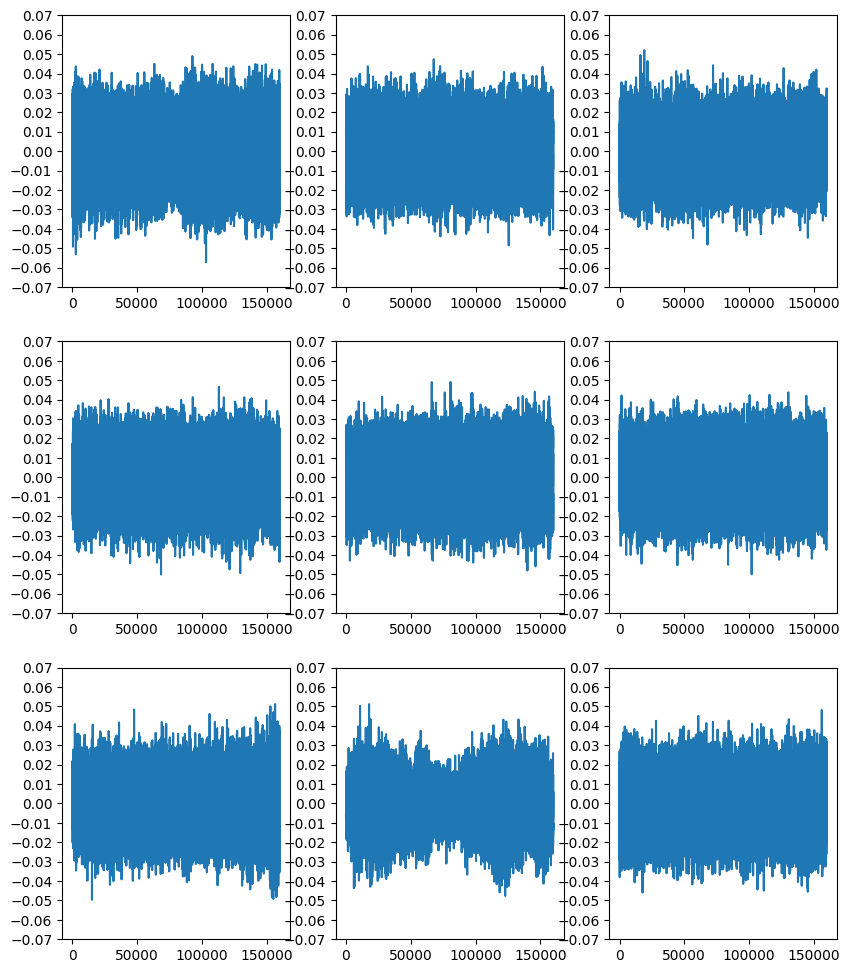

In [12]:
# いくつかのオーディオ波形をプロット

rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, audio in enumerate(waveform_ds.take(n)):

  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-0.07, 0.07, 0.01))

plt.show()

In [13]:
# 波形をフーリエ変換
# 周波数はlog10スケールに変換
def get_fft(waveform):
  waveform = tf.complex(waveform, 0.0)
  fft = tf.signal.fft(waveform)
  fft = tf.abs(fft)
  # Convert the frequencies to log scale and transpose
  fft_log_spec = tf.experimental.numpy.log10((fft + 2.2204460492503131e-16) / 2.2204460492503131e-16)
  fft_log_spec = fft_log_spec[0:len(fft)//2]
  return fft_log_spec

In [14]:
for waveform in waveform_ds.take(1):
  #label = label.numpy().decode('utf-8')
  # spectrogram = get_spectrogram(waveform)
  fft = get_fft(waveform)

#print('Label:', label)
print('Waveform shape:', waveform.shape)
#print('Spectrogram shape:', spectrogram.shape)
print('FFT shape:', fft.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=Sampling_freq))

Waveform shape: (160000,)
FFT shape: (80000,)
Audio playback


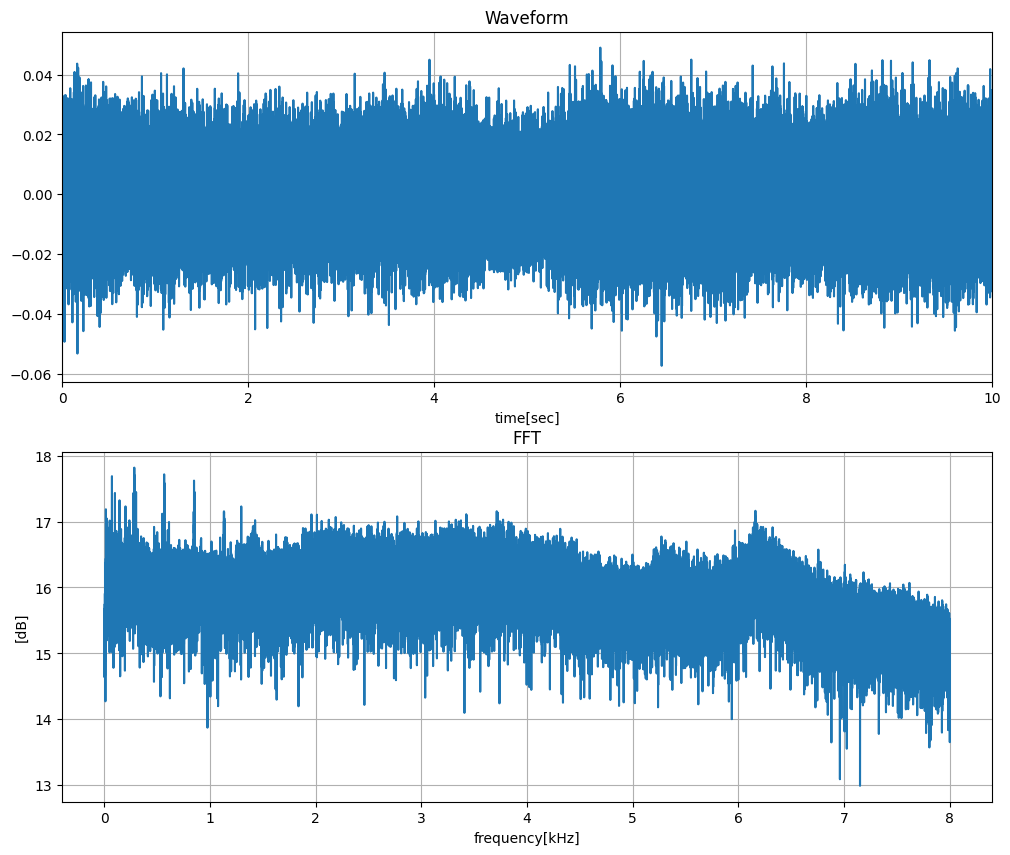

In [15]:
# 時間波形と周波数波形をプロット
timescale = np.arange(Data_num) #len(waveform)
timescale = timescale/Sampling_freq

freq = np.arange(Data_num//2) * Sampling_freq / Data_num

fig, axes = plt.subplots(2, figsize=(12, 10))

axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, Data_num/Sampling_freq]) # [0, Data_num]
axes[0].set_xlabel("time[sec]")
axes[0].grid()

axes[1].plot(freq/1000, fft)
axes[1].set_title('FFT')
axes[1].set_xlabel("frequency[kHz]")
axes[1].set_ylabel("[dB]")
axes[1].grid()
plt.show()

In [16]:
# AudioファイルをFFTへ変換

def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform,
      num_parallel_calls=AUTOTUNE
      )
  output_ds = output_ds.map(
      map_func=get_fft,
      num_parallel_calls=AUTOTUNE
      )#.batch(len(files))
  return output_ds

In [17]:
# 各データリストをFFTへ変換
train_ds = preprocess_dataset(train_data)
val_ds = preprocess_dataset(val_data)

train_ds = list(train_ds)
val_ds = list(val_ds)

In [18]:
# FFTの値を[0,1]の範囲へnormarization
min_val = tf.reduce_min(train_ds) # trainデータセットの最小値取得
max_val = tf.reduce_max(train_ds) # trainデータセットの最大値取得

train_ds = (train_ds - min_val) / (max_val - min_val) # [0,1]へ正規化
val_ds = (val_ds - min_val) / (max_val - min_val)   # [0,1]へ正規化 ※ trainデータの最小値・最大値を使用

train_ds = tf.cast(train_ds, tf.float32) # 型の変換
val_ds = tf.cast(val_ds, tf.float32)

In [19]:
input_shape = train_ds.shape
input_shape = input_shape[1]
print('Input shape:', input_shape)

Input shape: 80000


In [20]:
autoencoder = tf.keras.Sequential([
  layers.Dense(528, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(64, activation="relu", name = 'encoder'),
  layers.Dense(128, activation="relu"),
  layers.Dense(528, activation="relu"),
  layers.Dense(input_shape, activation="sigmoid")]) #

In [21]:
adam_low_rate = optimizers.Adam(learning_rate=1e-4)
autoencoder.compile(optimizer=adam_low_rate, loss='mse')

In [22]:
%%time

# オートエンコーダは正常の オーディオファイル のみを使用してトレーニング、
# 完全なテストセットを使用して評価されることに注意。

EPOCHS = 50
history = autoencoder.fit(train_ds, train_ds,
          epochs=EPOCHS,
          batch_size=512,
          validation_data=(val_ds, val_ds),
          shuffle=True,
          callbacks=tf.keras.callbacks.EarlyStopping(verbose=1,
                                                     patience=5,
                                                     monitor='val_loss'),
          )

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.0099 - val_loss: 0.0099
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0098 - val_loss: 0.0099
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - loss: 0.0097 - val_los

In [23]:
autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 528)                 │      42,240,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          67,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 528)                 │          68,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 80000)               │      42,320,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 254,138,786 (969.46 MB)

 Trainable params: 84,712,928 (323.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 169,425,858 (646.31 MB)

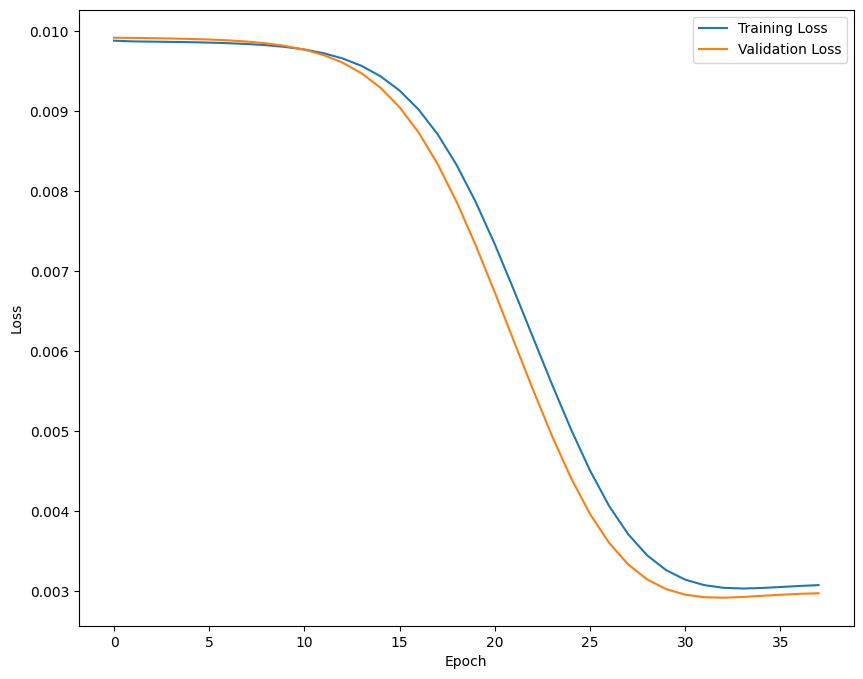

In [24]:
fig = plt.figure(figsize=(10, 8))

plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

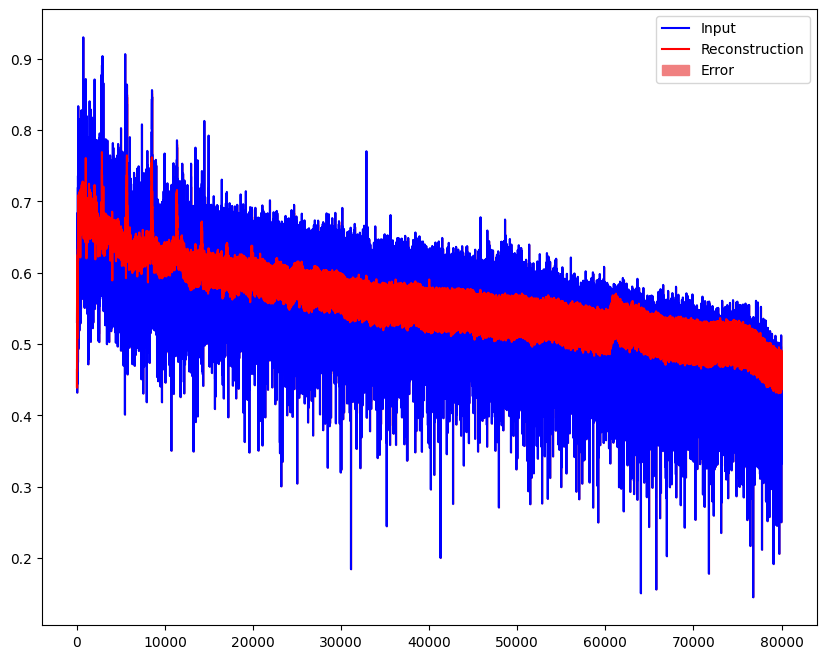

In [25]:
# 正常なテストサンプル

decoded_data = autoencoder(val_ds).numpy()

fig = plt.figure(figsize=(10, 8))

plt.plot(val_ds[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(input_shape), decoded_data[0], val_ds[0], color='lightcoral') #
plt.legend(labels=["Input", "Reconstruction", "Error"])
#plt.xlabel('frequency[Hz]')
plt.show()

## To Output Submitting CSV